# Carregamento, exploração e transformação dos dados
* Nesta fase, vamos explorar os dados, sendo necessárias algumas alterações em alguns casos, para descobrirmos quais informações podemos extrair do dataset

In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, to_date, datediff, current_date, expr, when, unix_timestamp, split, concat, lit
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, ChiSqSelector, PCA, OneHotEncoder
from pyspark.ml.stat import Summarizer, ChiSquareTest, Correlation
from scipy.stats import shapiro
from pyspark.ml.linalg import Vectors
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, shapiro
from pyspark.sql.types import DoubleType
from pyspark.mllib.stat import Statistics
from pyspark.ml.clustering import KMeans
import warnings
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator

warnings.filterwarnings("ignore")

In [88]:
spark = SparkSession.builder.appName('test').master('local[2]').getOrCreate()

In [89]:
file = './work/hr_dashboard_data.csv'

In [90]:
df = spark.read.csv(file, header=True, inferSchema=True)

In [91]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Projects Completed: integer (nullable = true)
 |-- Productivity (%): integer (nullable = true)
 |-- Satisfaction Rate (%): integer (nullable = true)
 |-- Feedback Score: double (nullable = true)
 |-- Department: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Joining Date: string (nullable = true)
 |-- Salary: integer (nullable = true)



In [92]:
df.show(2)

+----------------+---+------+------------------+----------------+---------------------+--------------+----------+--------+------------+------+
|            Name|Age|Gender|Projects Completed|Productivity (%)|Satisfaction Rate (%)|Feedback Score|Department|Position|Joining Date|Salary|
+----------------+---+------+------------------+----------------+---------------------+--------------+----------+--------+------------+------+
| Douglas Lindsey| 25|  Male|                11|              57|                   25|           4.7| Marketing| Analyst|      Jan-20| 63596|
|Anthony Roberson| 59|Female|                19|              55|                   76|           2.8|        IT| Manager|      Jan-99|112540|
+----------------+---+------+------------------+----------------+---------------------+--------------+----------+--------+------------+------+
only showing top 2 rows



In [93]:
dfNullValues = df.select([col(c).isNull().cast('int').alias(c) for c in df.columns]) #verifica existência de valores nulos



In [94]:
dfNullValues.groupBy().sum().show()

+---------+--------+-----------+-----------------------+---------------------+--------------------------+-------------------+---------------+-------------+-----------------+-----------+
|sum(Name)|sum(Age)|sum(Gender)|sum(Projects Completed)|sum(Productivity (%))|sum(Satisfaction Rate (%))|sum(Feedback Score)|sum(Department)|sum(Position)|sum(Joining Date)|sum(Salary)|
+---------+--------+-----------+-----------------------+---------------------+--------------------------+-------------------+---------------+-------------+-----------------+-----------+
|        0|       0|          0|                      0|                    0|                         0|                  0|              0|            0|                0|          0|
+---------+--------+-----------+-----------------------+---------------------+--------------------------+-------------------+---------------+-------------+-----------------+-----------+



In [95]:
age = df.select('Age').rdd.flatMap(lambda x: x).collect()

<Axes: ylabel='Count'>

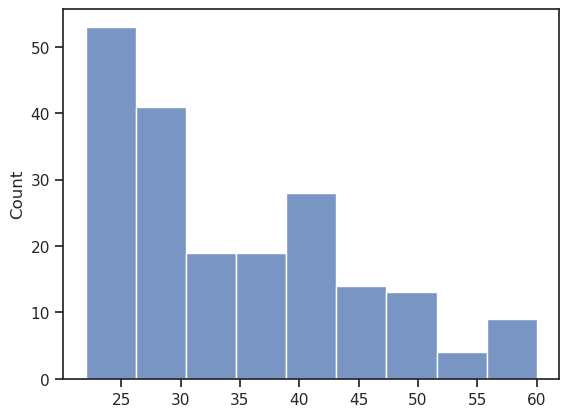

In [96]:
sns.histplot(data = age)

In [97]:
satisfacDepart = df.groupBy('Department').agg({'Satisfaction Rate (%)' : 'median'}).withColumnRenamed('median(Satisfaction Rate (%))', 'medianSatisfact').orderBy(desc('medianSatisfact')).show()

+----------+---------------+
|Department|medianSatisfact|
+----------+---------------+
|        HR|           58.5|
|        IT|           58.0|
|   Finance|           49.0|
|     Sales|           45.0|
| Marketing|           37.5|
+----------+---------------+



In [98]:
satisfact = df.select('Satisfaction Rate (%)').rdd.flatMap(lambda x: x).collect()

In [99]:
produtivity = df.select('Productivity (%)').rdd.flatMap(lambda x: x).collect()

Text(0.5, 1.0, 'Relação de satisfação com produtividade')

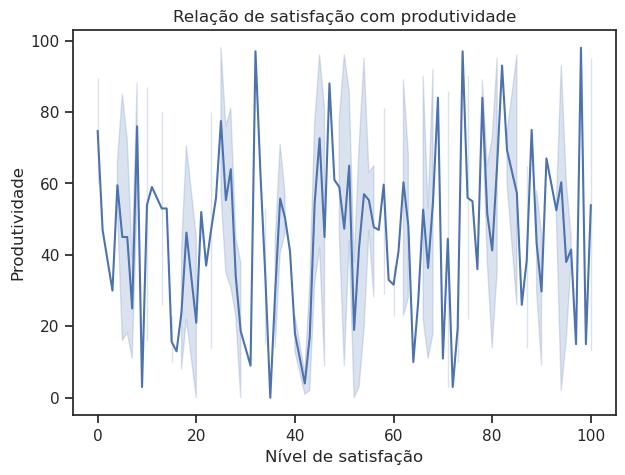

In [100]:
plt.figure(figsize=(7,5))
sns.lineplot(x= satisfact, y= produtivity)
plt.xlabel('Nível de satisfação')
plt.ylabel('Produtividade')
plt.title('Relação de satisfação com produtividade')

Text(0.5, 1.0, 'Boxplot produtividade')

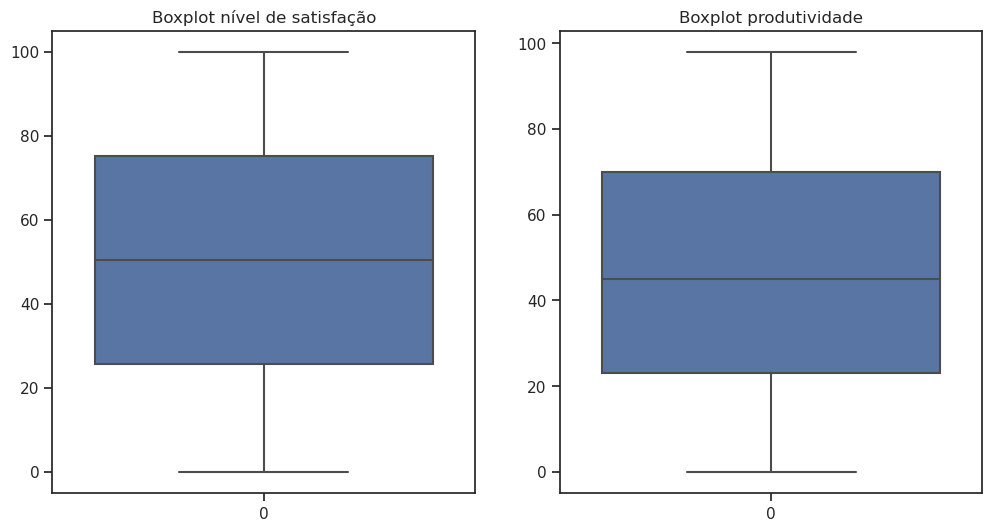

In [101]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(satisfact)
plt.title('Boxplot nível de satisfação')

plt.subplot(1,2,2)
sns.boxplot(produtivity)
plt.title('Boxplot produtividade')

In [102]:
feedBackScore = df.select('Feedback Score').rdd.flatMap(lambda x: x).collect()

Text(0.5, 1.0, 'Relação de produtividade e feedBack')

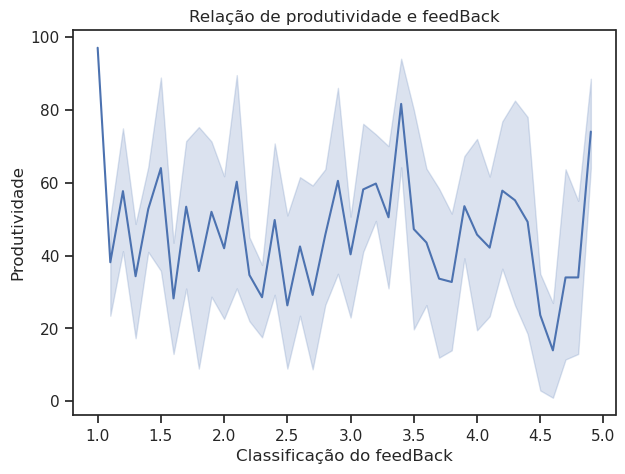

In [103]:
plt.figure(figsize=(7,5))
sns.lineplot(x= feedBackScore, y=produtivity )
plt.xlabel('Classificação do feedBack')
plt.ylabel('Produtividade')
plt.title('Relação de produtividade e feedBack')

In [104]:
salary = df.select('Salary').rdd.flatMap(lambda x: x).collect()

Text(0, 0.5, 'Produtividade')

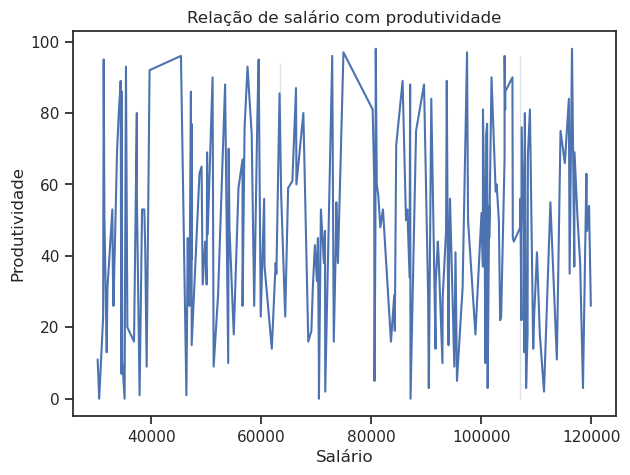

In [105]:
plt.figure(figsize=(7,5))
sns.lineplot(x= salary, y= produtivity)
plt.title('Relação de salário com produtividade')
plt.xlabel('Salário')
plt.ylabel('Produtividade')

In [106]:
projects = df.select('Projects Completed').rdd.flatMap(lambda x: x).collect()

Text(0, 0.5, 'Satisfação')

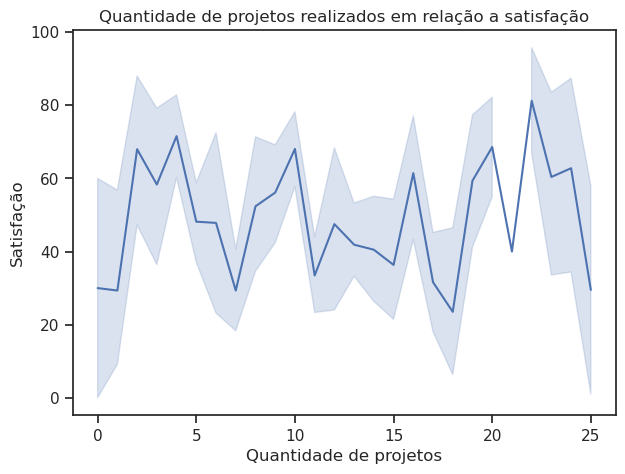

In [107]:
plt.figure(figsize=(7,5))
sns.lineplot(x= projects, y= satisfact)
plt.title('Quantidade de projetos realizados em relação a satisfação')
plt.xlabel('Quantidade de projetos')
plt.ylabel('Satisfação')

In [108]:
split_col = split(df['Joining Date'], '-')

In [109]:
df_new_columns = df.withColumn('year', split_col.getItem(1).cast('int')).withColumn('month', split_col.getItem(0))

In [110]:
df_transformed = df_new_columns.withColumn("n_date", when(col("year") > 23, col("year") + 1900).when(col("year") < 23, col("year") + 2000).otherwise(col("year")))

In [111]:
df_new_date = df_transformed.withColumn('Joining Date', concat(col('month'), lit('-'), col('n_date')))

In [112]:
df_new_date = df_new_date.withColumn('Joining Date', to_date('Joining Date', 'MMM-yyyy'))

In [113]:
joining_date = df_new_date.select('Joining Date').rdd.flatMap(lambda x: x).collect()

Text(0.5, 1.0, 'Relação data de início e produtividade')

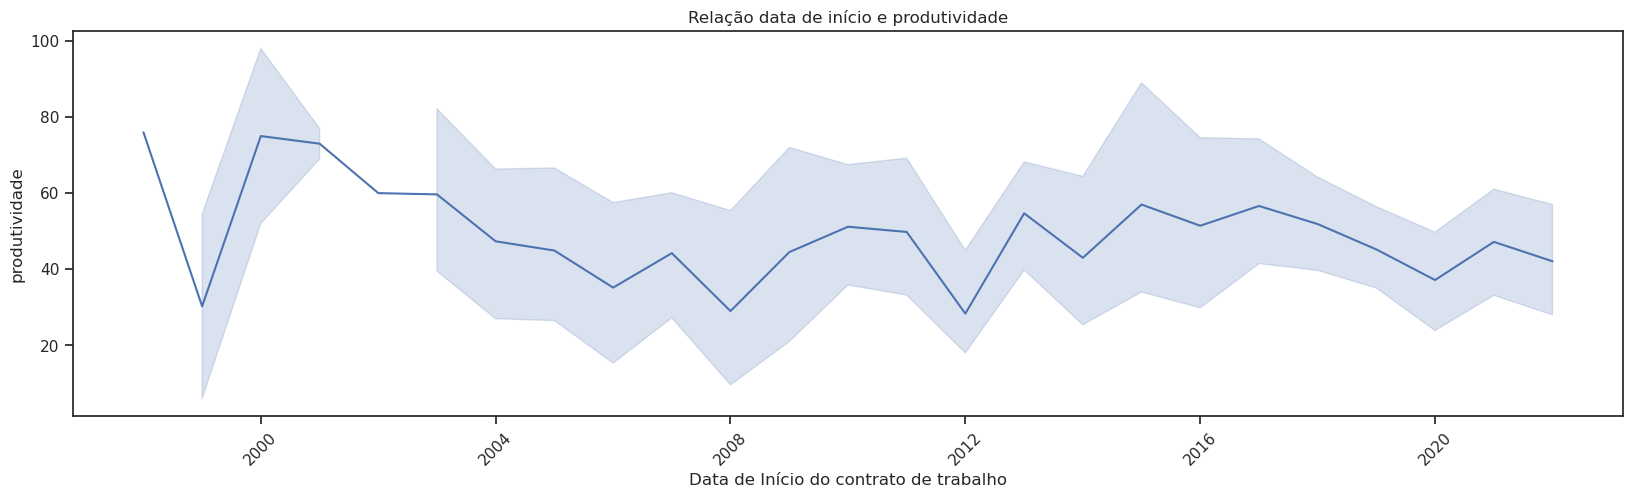

In [114]:
plt.figure(figsize=(20,5))
sns.lineplot(x= joining_date, y=produtivity)
plt.xticks(rotation=45)
plt.xlabel('Data de Início do contrato de trabalho')
plt.ylabel('produtividade')
plt.title('Relação data de início e produtividade')

In [115]:
columns_drop = ['year','month','n_date','Name']

In [116]:
df = df_new_date.select([ col for col in df_new_date.columns if col not in columns_drop])

In [117]:
gender = df.select('Gender').rdd.flatMap(lambda x: x).collect()

Text(0, 0.5, 'Classificação do FeedBack')

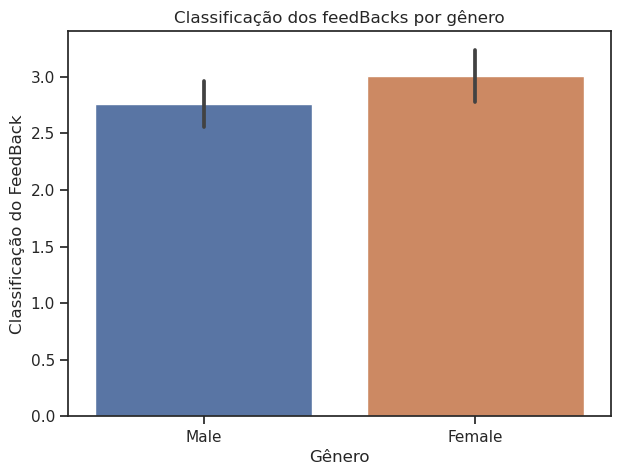

In [118]:
plt.figure(figsize=(7,5))
sns.barplot(x= gender, y= feedBackScore)
plt.title('Classificação dos feedBacks por gênero')
plt.xlabel('Gênero')
plt.ylabel('Classificação do FeedBack')

# Verificação da distribuição dos dados numéricos
* Iremos verificar se os dados numéricos seguem distribuição normal para definirmos qual modelo estatístico adotar para testar a independência entre eles

In [119]:
categorical_cols = ['Gender','Department','Position']


In [120]:
indexers = [StringIndexer(inputCol=col, outputCol= col+"_index").fit(df) for col in categorical_cols]

In [121]:
indexed_data = df

In [122]:
for indexer in indexers:
    indexed_data = indexer.transform(indexed_data)

In [123]:
indexed_data = indexed_data.withColumn("Data_unix", unix_timestamp("Joining Date", "yyyy-MM-dd"))

In [124]:
numeric_cols = ['Age','Projects Completed','Productivity (%)','Satisfaction Rate (%)','Feedback Score','Salary','Data_unix']

In [125]:
for i in numeric_cols:
    x = indexed_data.select(i).rdd.flatMap(lambda x:x).collect()
    y = stats.shapiro(x).statistic
    print(f'p-value de {i}: {y}')

p-value de Age: 0.9121652245521545
p-value de Projects Completed: 0.9684268832206726
p-value de Productivity (%): 0.9567469358444214
p-value de Satisfaction Rate (%): 0.9553185105323792
p-value de Feedback Score: 0.9514918923377991
p-value de Salary: 0.9383205771446228
p-value de Data_unix: 0.8923117518424988


* Teste de Shapiro Wilk sugere não que possuímos evidências suficientes para rejeitar a hipótese nulo de que os dados possuem distribuição normal

# Vamos verificar se as difirenças dos grupos podem ser dadas ao acaso usando teste chi-quadrado para dados categóricos e teste ANOVA para dados numéricos

In [126]:
for col_name in categorical_cols:
    x = indexed_data.select(col_name+'_index').rdd.flatMap(lambda x:x).collect()
    y = Statistics.chiSqTest(x)
    print(f'Resultado Chi_test de {col_name}: {y}')

Resultado Chi_test de Gender: Chi squared test summary:
method: pearson
degrees of freedom = 199 
statistic = 100.0 
pValue = 0.9999999995447523 
No presumption against null hypothesis: observed follows the same distribution as expected..
Resultado Chi_test de Department: Chi squared test summary:
method: pearson
degrees of freedom = 199 
statistic = 213.23497267759583 
pValue = 0.23256435528540775 
No presumption against null hypothesis: observed follows the same distribution as expected..
Resultado Chi_test de Position: Chi squared test summary:
method: pearson
degrees of freedom = 199 
statistic = 254.62740899357624 
pValue = 0.004704746137730309 
Very strong presumption against null hypothesis: observed follows the same distribution as expected..


* Teste Chi-quadrado sugere que apenas os dados contidos na coluna Position possuem evidências para rejeitar a hipótese nula de que não há associação significativa entra as variáveis

In [127]:
current_date_col = current_date()
indexed_data = indexed_data.withColumn("TimeWorked", datediff(current_date_col, col("Joining Date")))

In [128]:
df_numerics = indexed_data.select('Age','Projects Completed','Productivity (%)','Satisfaction Rate (%)','Feedback Score','Salary','TimeWorked')

In [129]:
assembler = VectorAssembler(inputCols= df_numerics.columns, outputCol= 'features')
df_assembled = assembler.transform(df_numerics)

In [130]:
numeric_columns = df_numerics.columns

In [131]:
features = df_assembled.select('features').rdd.flatMap(lambda x: x).collect()

In [132]:
anova_results = f_oneway(*features)

In [133]:
print("F-value:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

F-value: 0.12983392190536847
p-value: 0.9999999999999999


* Teste ANOVA demonstra que as diferenças entre os grupos podem ser atribuídas ao acaso

# Correlação entre dados numéricos

In [134]:
numeric_cols1 = df_numerics.columns

In [135]:
vector_assembler = VectorAssembler(inputCols=numeric_cols1, outputCol="features")
df_assembled1 = vector_assembler.transform(df_numerics).select("features")

correlation_matrix = Correlation.corr(df_assembled1, "features").head()[0]


In [136]:
correlation_array = correlation_matrix.toArray()

In [137]:
correlation_df = pd.DataFrame(correlation_array, columns=numeric_cols1, index=numeric_cols1)

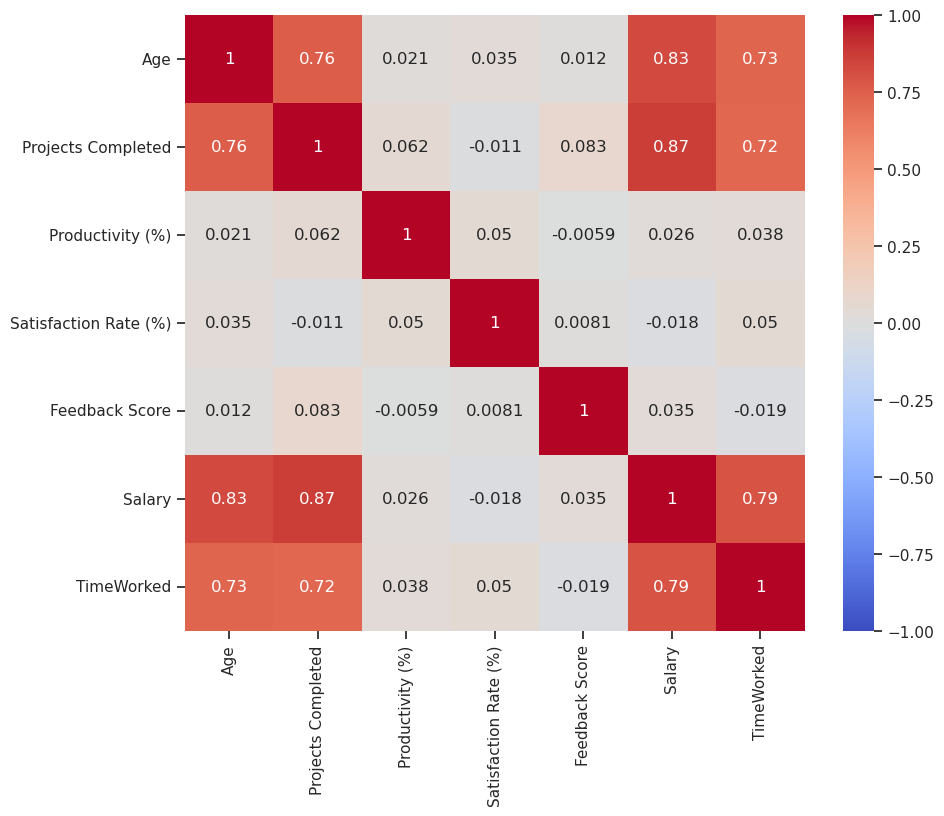

In [138]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

# Preparando dados para a clusterização 


In [139]:
encoder = OneHotEncoder(inputCols=['Gender_index', 'Department_index', 'Position_index'], outputCols=['Gender_encoded', 'Department_encoded', 'Position_encoded'])
encoded_data = encoder.fit(indexed_data).transform(indexed_data)

In [140]:
select_cols = ['Projects Completed','Productivity (%)','Satisfaction Rate (%)','Feedback Score','Salary','TimeWorked','Gender_encoded','Department_encoded','Position_encoded']

In [141]:
assembler = VectorAssembler(inputCols=select_cols, outputCol='features')
data_assembled = assembler.transform(encoded_data)

In [142]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)

# Escolha da quantidade ideal de clusters com método Silhueta

In [143]:
silhouette_scores = []

for num_clusters in range(2, 11):
    kmeans = KMeans().setK(num_clusters).setSeed(1)
    model = kmeans.fit(data_scaled)
    
    predictions = model.transform(data_scaled)
    
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    
    silhouette_scores.append((num_clusters, silhouette_score))

In [144]:
result_df = spark.createDataFrame(silhouette_scores, ["num_clusters", "silhouette_score"])

best_num_clusters = result_df.orderBy("silhouette_score", ascending=False).first().num_clusters

print("Número ideal de clusters:", best_num_clusters)

Número ideal de clusters: 2


In [145]:
num_clusters = np.array(result_df.select("num_clusters").collect())
silhouette_scores = np.array(result_df.select("silhouette_score").collect())

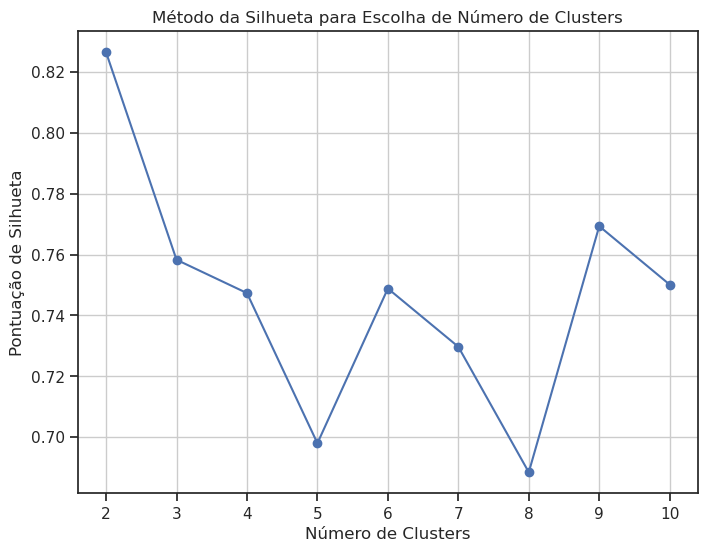

In [146]:
plt.figure(figsize=(8, 6))
plt.plot(num_clusters, silhouette_scores, marker="o")
plt.title("Método da Silhueta para Escolha de Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Pontuação de Silhueta")
plt.grid(True)
plt.show()

In [147]:
kmeans = KMeans(k=2, seed=1, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(data_scaled)

In [148]:
clustered_data = model.transform(data_scaled)

In [149]:
df_pd = clustered_data.toPandas()

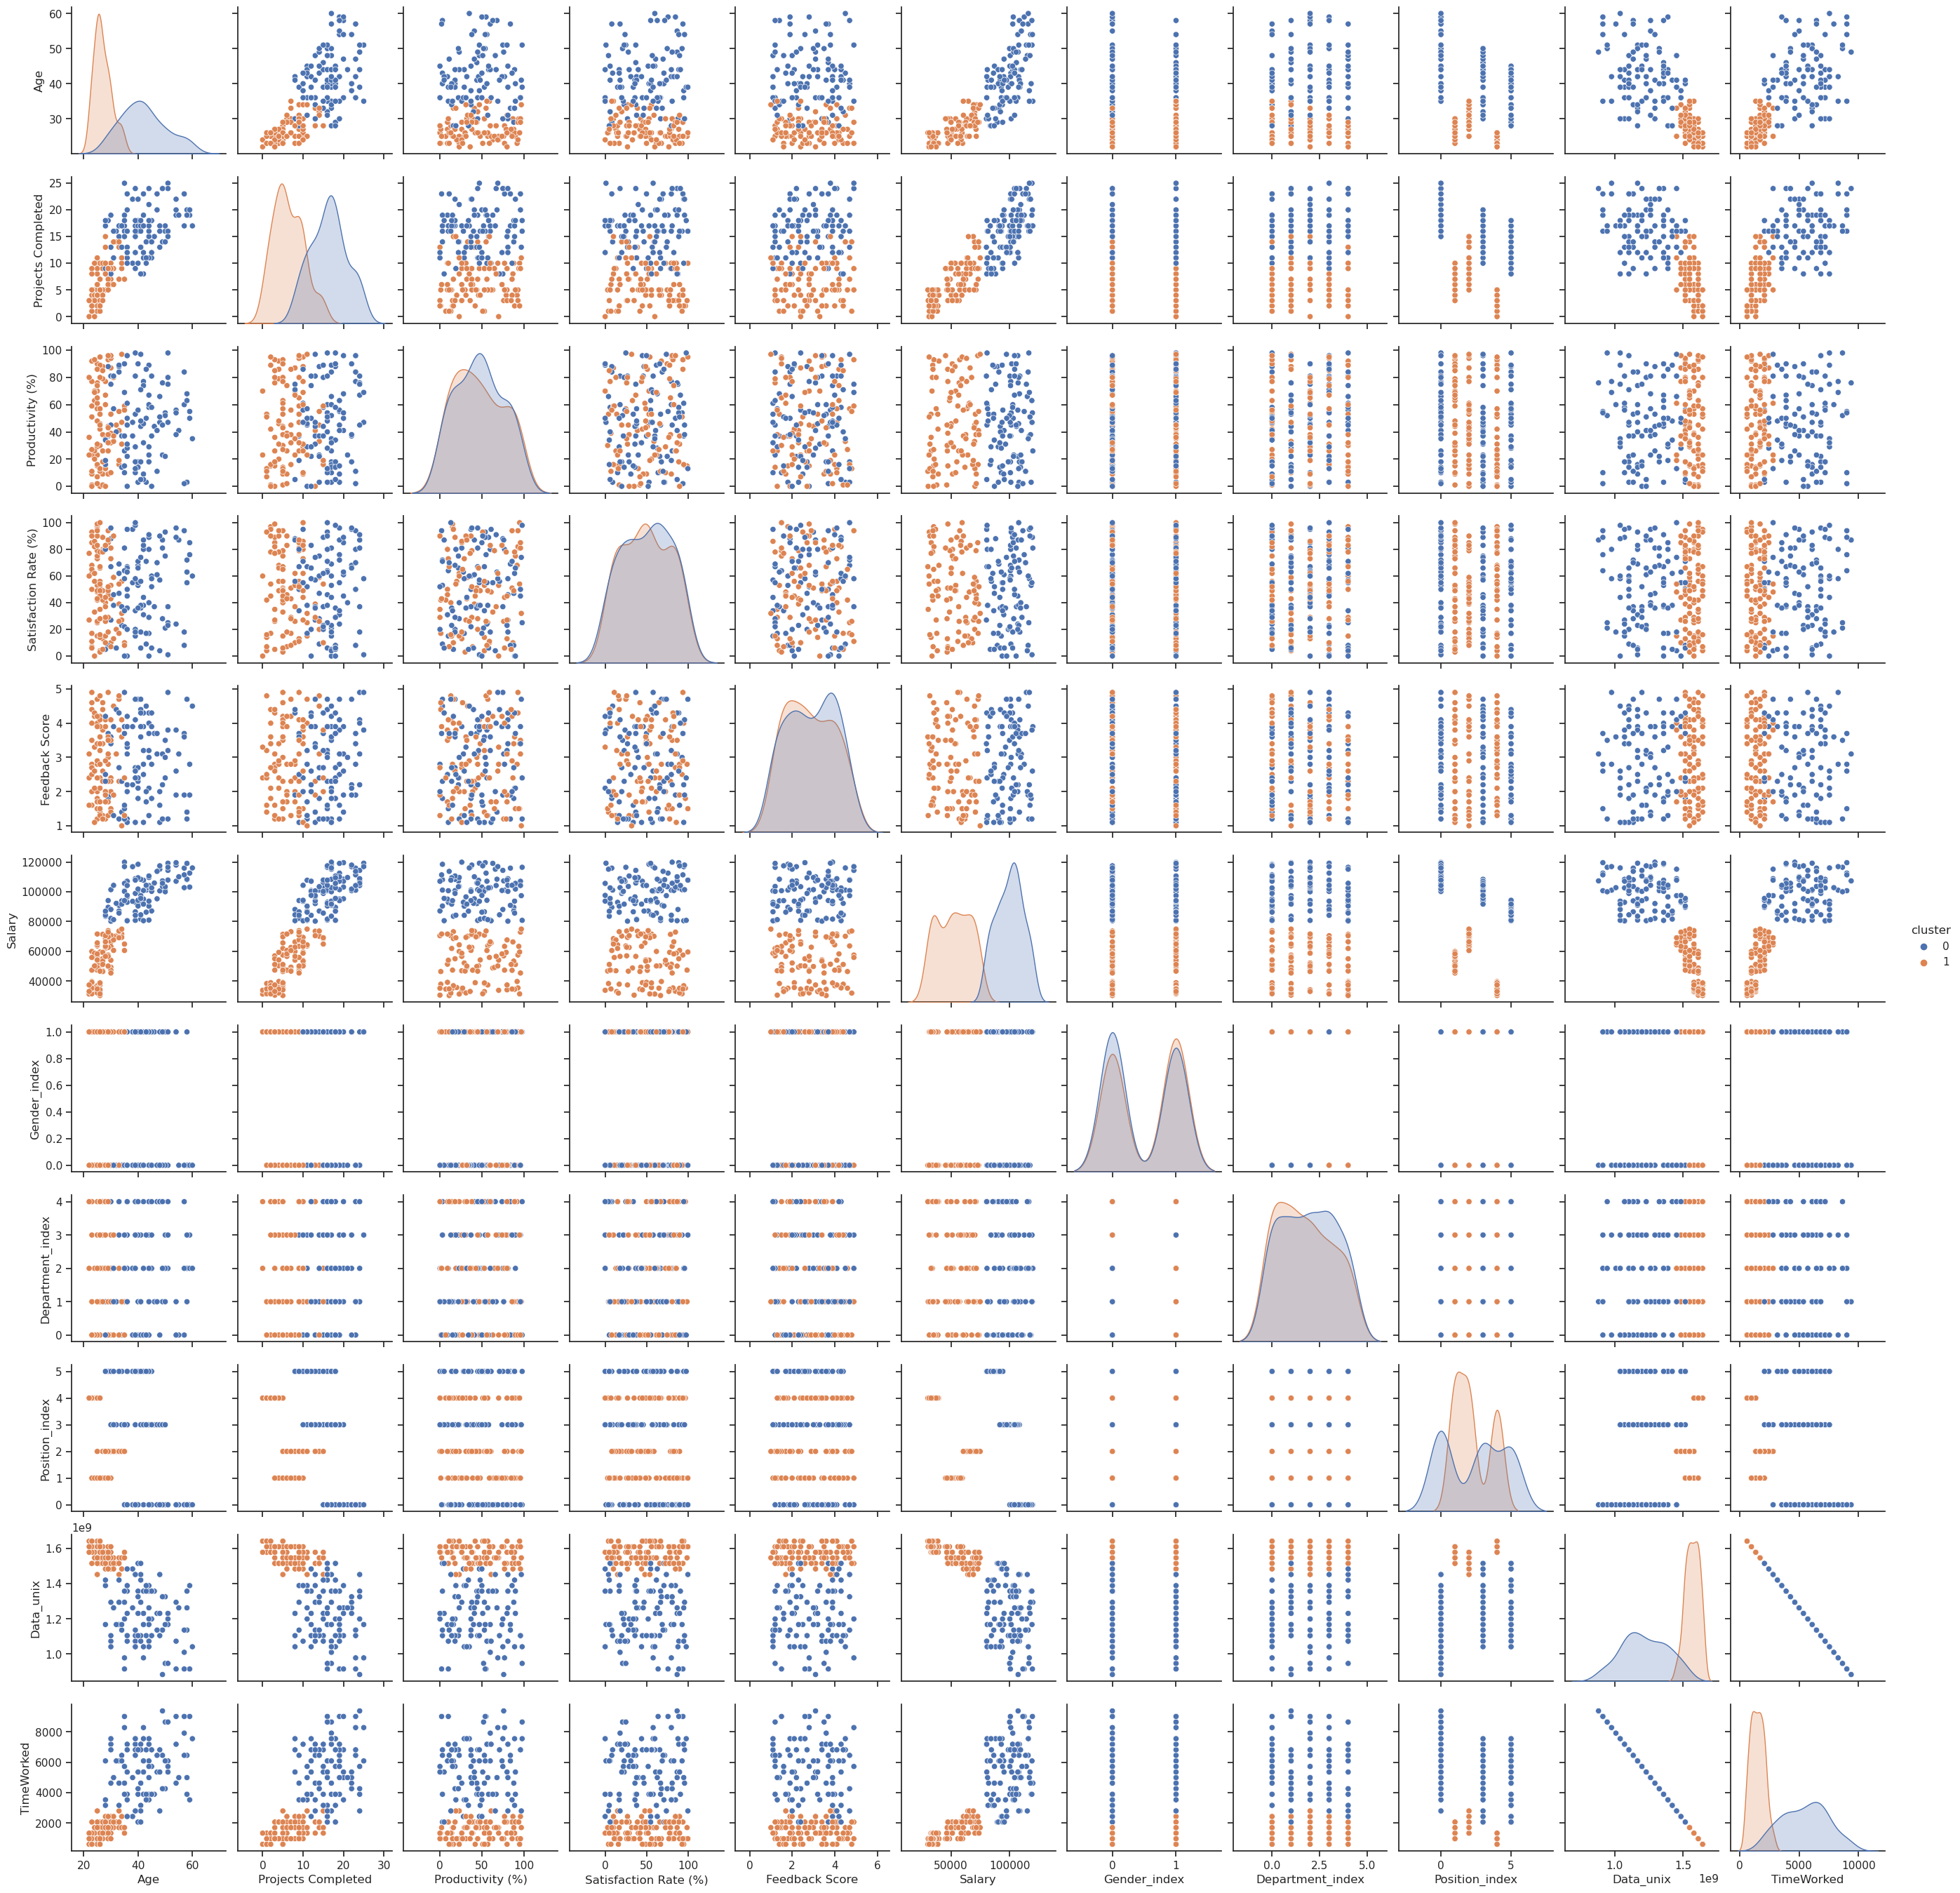

In [150]:
sns.set_theme(style="ticks")

sns.pairplot(df_pd, hue="cluster")

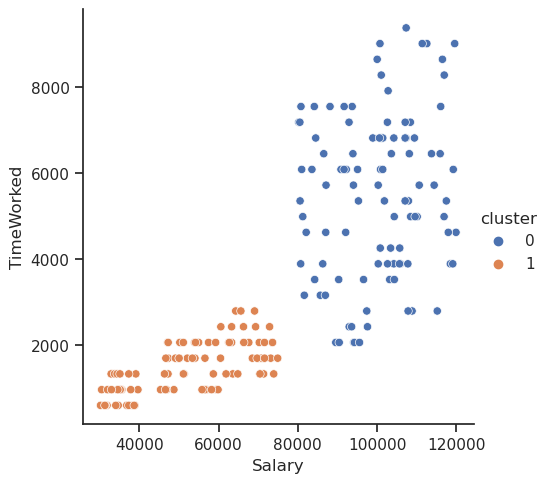

In [151]:
sns.relplot(x="Salary", y="TimeWorked", hue="cluster", height=5, data=df_pd)

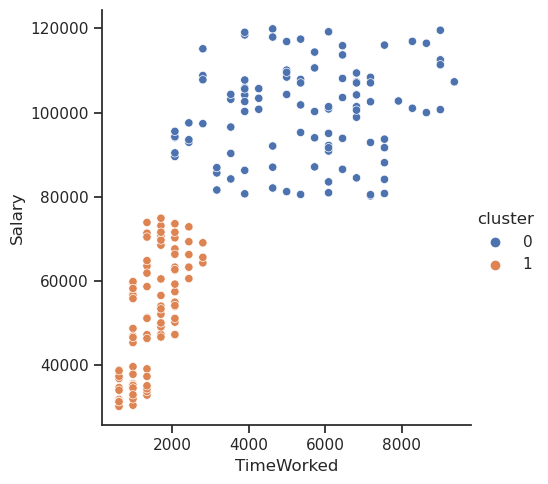

In [152]:
sns.relplot(x="TimeWorked", y="Salary", hue="cluster", height=5, data=df_pd)

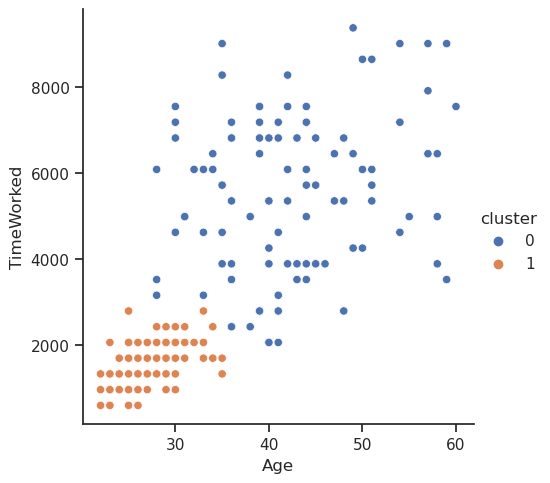

In [153]:
sns.relplot(x="Age", y="TimeWorked", hue="cluster", height=5, data=df_pd)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Analyst'),
  Text(1, 0, 'Manager'),
  Text(2, 0, 'Intern'),
  Text(3, 0, 'Team Lead'),
  Text(4, 0, 'Junior Developer'),
  Text(5, 0, 'Senior Developer')])

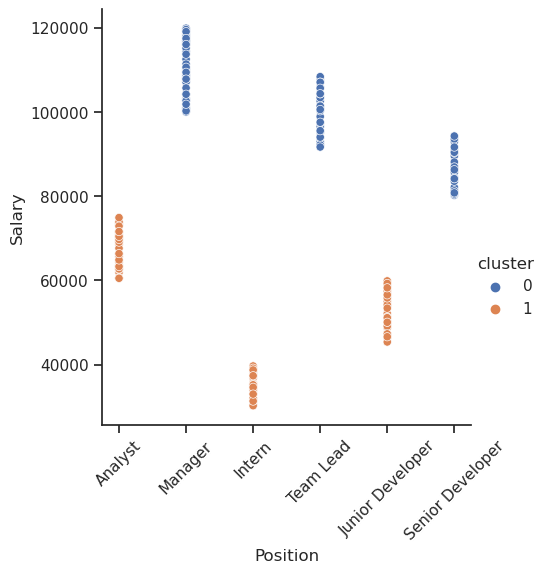

In [154]:
sns.relplot(x="Position", y="Salary", hue="cluster", height=5, data=df_pd)
plt.xticks(rotation=45)

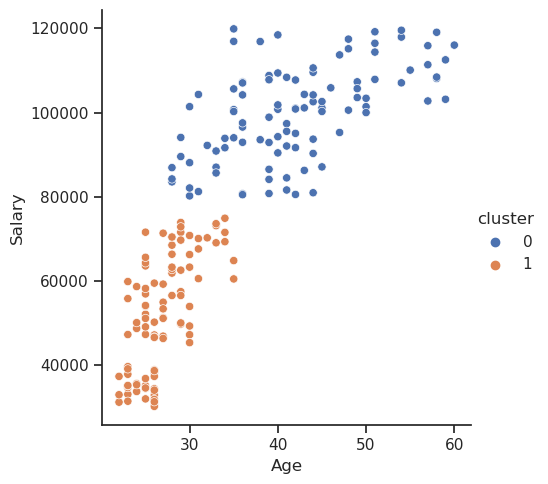

In [155]:
sns.relplot(x="Age", y="Salary", hue="cluster", height=5, data=df_pd)

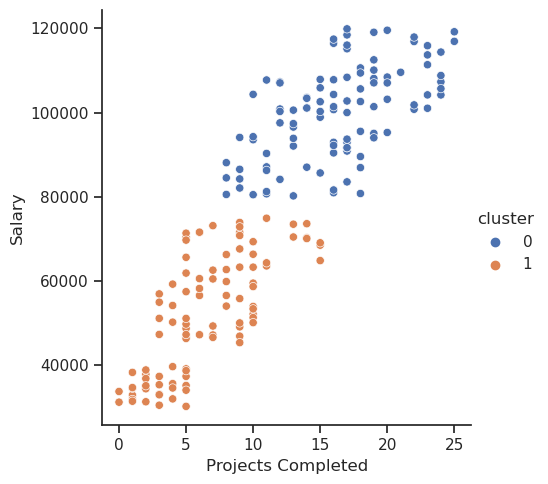

In [156]:
sns.relplot(x="Projects Completed", y="Salary", hue="cluster", height=5, data=df_pd)

# Random Forest para observamos as features mais relevantes

In [157]:
clustered_data.show(2)

+---+------+------------------+----------------+---------------------+--------------+----------+--------+------------+------+------------+----------------+--------------+----------+----------+--------------+------------------+----------------+--------------------+--------------------+-------+
|Age|Gender|Projects Completed|Productivity (%)|Satisfaction Rate (%)|Feedback Score|Department|Position|Joining Date|Salary|Gender_index|Department_index|Position_index| Data_unix|TimeWorked|Gender_encoded|Department_encoded|Position_encoded|            features|     scaled_features|cluster|
+---+------+------------------+----------------+---------------------+--------------+----------+--------+------------+------+------------+----------------+--------------+----------+----------+--------------+------------------+----------------+--------------------+--------------------+-------+
| 25|  Male|                11|              57|                   25|           4.7| Marketing| Analyst|  2020-01-01|

In [158]:
rf_model = RandomForestClassifier(featuresCol="features", labelCol="cluster").fit(clustered_data)


In [159]:
feature_importance = rf_model.featureImportances

In [160]:
feature_cols = select_cols

In [161]:
for idx, importance in zip(range(9), feature_importance):
    print(f"Feature {feature_cols[idx]} importance: {importance}")

Feature Projects Completed importance: 0.08293486085846923
Feature Productivity (%) importance: 0.009257717864332805
Feature Satisfaction Rate (%) importance: 0.0010533393296201367
Feature Feedback Score importance: 3.827124728763779e-05
Feature Salary importance: 0.5541442835096719
Feature TimeWorked importance: 0.19276778600346903
Feature Gender_encoded importance: 0.0
Feature Department_encoded importance: 0.002567275424853262
Feature Position_encoded importance: 0.0006985589934898693


# Obtendo o PCA

In [163]:
num_components = 2

In [164]:
pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_data)
df_pca = pca_model.transform(clustered_data)


In [165]:
df_pca.select("pca_features").show(truncate=False)

+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-63529.38328739506,3202.9025165853795] |
|[-112895.89632438034,-955.4819092284796]|
|[-66296.6408849163,2303.069223692307]   |
|[-38248.68858781312,2127.4290745496087] |
|[-101361.56859075214,417.2033653738651] |
|[-48685.131251025734,2507.9749921597586]|
|[-73462.22126645147,3181.537853772925]  |
|[-39638.24777822057,1860.7433642206977] |
|[-49318.8016960336,1820.4335345932316]  |
|[-93190.62856572037,-534.2342558689993] |
|[-80793.10677339137,1875.2128515827599] |
|[-95263.93137776024,712.8397007758058]  |
|[-35148.71639292057,1539.5823576489945] |
|[-70239.45676363156,2951.042043192264]  |
|[-89490.26924845164,4328.095837932112]  |
|[-118441.9068313499,4568.369272029742]  |
|[-105900.95251332107,3671.2954910705316]|
|[-92169.32942089012,1956.1770715583816] |
|[-107491.90334785641,855.5946634779344] |
|[-37827.87176057187,1731.3984229229443] |
+----------

In [184]:
principal_components = pca_model.pc.toArray()


In [185]:
print("Principal Components:")
for i, component in enumerate(principal_components):
    print(f"PC{i + 1}: {component}")


Principal Components:
PC1: [-0.00020643 -0.00022829]
PC2: [-2.69386791e-05 -5.66475914e-04]
PC3: [ 1.90627313e-05 -2.02367938e-03]
PC4: [-1.42809127e-06  5.65519401e-05]
PC5: [-0.99745131  0.07135   ]
PC6: [-0.07135013 -0.9974491 ]
PC7: [-2.51674274e-07 -7.18190815e-06]
PC8: [ 9.17675753e-07 -7.12068736e-06]
PC9: [3.65923310e-07 2.31207383e-05]
PC10: [-1.02832913e-06  7.55387927e-06]
PC11: [-9.53414904e-07 -1.86654054e-05]
PC12: [-9.15137459e-06 -6.50325268e-06]
PC13: [5.86765782e-06 1.78338743e-05]
PC14: [1.91542506e-06 7.20893476e-05]
PC15: [-5.16668754e-06 -1.70902294e-05]
PC16: [ 8.56581041e-06 -2.56652382e-05]
